In [19]:
# dataset from: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
import numpy as np
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt 
import torch 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from datasets import load_dataset 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from torchinfo import summary

In [6]:
df_ = pd.read_csv('datasets/AirlineTweets.csv')

In [5]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df = df_[['airline_sentiment', 'text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

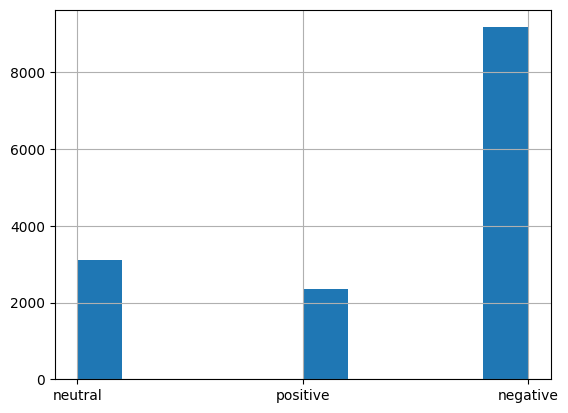

In [8]:
#imbalanced dataset, check if model can handle 
df['airline_sentiment'].hist()

In [8]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [9]:
df2 = df[['text', 'target']]
# for whatever reason, column named 'label' is required, otherwise you encounter errors in training. Was not clearly mentioned in docs as well.
df2.columns = ['text', 'label']
df2.to_csv('datasets/airline_data.csv', index=None)

In [10]:
# can pass a list of filenames to data_files, and if splits already present, pass a dictionary with 'train' and 'test' as keys, with one file or lists of filenames being values. File paths can be URLs as well
raw_dataset = load_dataset('csv', data_files='datasets/airline_data.csv')

Generating train split: 0 examples [00:00, ? examples/s]c:\Users\91959\Desktop\Personal\projects\transformers\venv\Lib\site-packages\datasets\download\streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)
Generating train split: 14640 examples [00:00, 172362.37 examples/s]


In [12]:
raw_dataset 

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14640
    })
})

In [11]:
#using the Dataset object's train_test_split method
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [14]:
split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4392
    })
})

In [15]:
checkpoint = 'distilbert-base-cased'

In [16]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [17]:
#Trainer handles padding automatically
def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True)

In [18]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map: 100%|██████████| 4392/4392 [00:00<00:00, 23781.31 examples/s]


In [19]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [21]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
#custom metrics for custom dataset
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': accuracy, 'f1': f1} 

In [24]:
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

  0%|          | 0/1923 [00:00<?, ?it/s]

 26%|██▌       | 501/1923 [00:42<02:00, 11.79it/s]

{'loss': 0.5281, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}


                                                  
 33%|███▎      | 641/1923 [01:00<01:44, 12.31it/s]

{'eval_loss': 0.4221201241016388, 'eval_accuracy': 0.8299180327868853, 'eval_f1': 0.7659427205620201, 'eval_runtime': 6.8292, 'eval_samples_per_second': 643.122, 'eval_steps_per_second': 10.104, 'epoch': 1.0}


 52%|█████▏    | 1001/1923 [01:32<01:15, 12.16it/s]

{'loss': 0.3436, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}


                                                   
 67%|██████▋   | 1282/1923 [02:03<00:57, 11.24it/s]

{'eval_loss': 0.4789360761642456, 'eval_accuracy': 0.8335610200364298, 'eval_f1': 0.7746961553998365, 'eval_runtime': 6.978, 'eval_samples_per_second': 629.41, 'eval_steps_per_second': 9.888, 'epoch': 2.0}


 78%|███████▊  | 1501/1923 [02:23<00:36, 11.51it/s]

{'loss': 0.2196, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}


                                                   
100%|██████████| 1923/1923 [03:07<00:00, 11.73it/s]

{'eval_loss': 0.6292389631271362, 'eval_accuracy': 0.8385701275045537, 'eval_f1': 0.7858133429599028, 'eval_runtime': 7.086, 'eval_samples_per_second': 619.81, 'eval_steps_per_second': 9.737, 'epoch': 3.0}


100%|██████████| 1923/1923 [03:08<00:00, 10.21it/s]

{'train_runtime': 188.3857, 'train_samples_per_second': 163.197, 'train_steps_per_second': 10.208, 'train_loss': 0.31701711733020105, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.31701711733020105, metrics={'train_runtime': 188.3857, 'train_samples_per_second': 163.197, 'train_steps_per_second': 10.208, 'train_loss': 0.31701711733020105, 'epoch': 3.0})

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
saved_model = pipeline(
    'text-classification',
    model='./training_dir/checkpoint-1282/',
    device=device,
)

cuda


In [12]:
split['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 4392
})

In [13]:
test_predictions = saved_model(split['test']['text'])

In [14]:
test_predictions

[{'label': 'LABEL_1', 'score': 0.9675998687744141},
 {'label': 'LABEL_1', 'score': 0.9718480110168457},
 {'label': 'LABEL_0', 'score': 0.9023616909980774},
 {'label': 'LABEL_1', 'score': 0.831093430519104},
 {'label': 'LABEL_0', 'score': 0.6410403251647949},
 {'label': 'LABEL_0', 'score': 0.9953162670135498},
 {'label': 'LABEL_2', 'score': 0.8852987289428711},
 {'label': 'LABEL_2', 'score': 0.7866281867027283},
 {'label': 'LABEL_1', 'score': 0.804694652557373},
 {'label': 'LABEL_0', 'score': 0.9948238134384155},
 {'label': 'LABEL_0', 'score': 0.990311861038208},
 {'label': 'LABEL_0', 'score': 0.9957875609397888},
 {'label': 'LABEL_1', 'score': 0.9660772085189819},
 {'label': 'LABEL_0', 'score': 0.9961275458335876},
 {'label': 'LABEL_2', 'score': 0.9867421984672546},
 {'label': 'LABEL_1', 'score': 0.6209919452667236},
 {'label': 'LABEL_0', 'score': 0.8552086353302002},
 {'label': 'LABEL_0', 'score': 0.9972119927406311},
 {'label': 'LABEL_0', 'score': 0.8605552315711975},
 {'label': 'LAB

In [15]:
#converting labels to int
def get_label(prediction):
    return int(prediction['label'].split('_')[1])
    
test_predictions = [get_label(prediction) for prediction in test_predictions]

In [16]:
test_predictions

[1,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,


In [17]:
print('accuracy: ', accuracy_score(split['test']['label'], test_predictions))

accuracy:  0.8335610200364298


In [18]:
print('f1: ', f1_score(split['test']['label'], test_predictions, average='macro'))

f1:  0.7746961553998365


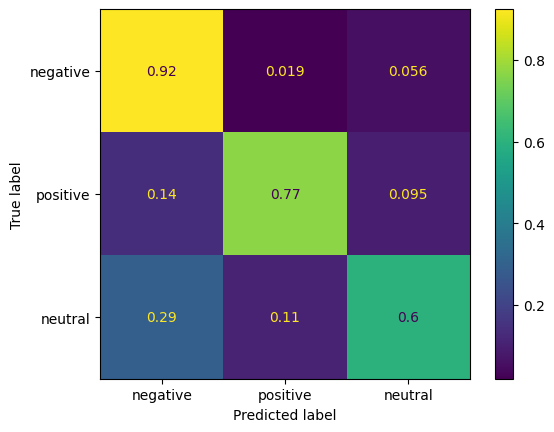

In [24]:
ConfusionMatrixDisplay.from_predictions(split['test']['label'], test_predictions, normalize='true', display_labels=['negative', 'positive', 'neutral'])